**Loading Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics.pairwise import cosine_similarity
import os

**Image Loading and augumentations**

**Trained on a subset of data from [Kaggle Signature Dataset](https://www.kaggle.com/robinreni/signature-verification-dataset).** Took only 10 classes

In [12]:
train_directory = r"C:\Users\abhay\OneDrive\Documents\Flashaid\Signature\sign_data_kaggle_modified\train"
test_directory = r"C:\Users\abhay\OneDrive\Documents\Flashaid\Signature\sign_data_kaggle_modified\train"

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 0.1,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.1
)

train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size = (224, 224),
    color_mode = 'rgb',
    shuffle = True,
    batch_size=32
    
)


test_datagen = ImageDataGenerator(
    rescale = 1./255,
)

test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size = (224, 224),
    color_mode = 'rgb',
    shuffle = True,
    batch_size=32
)

Found 175 images belonging to 10 classes.
Found 175 images belonging to 10 classes.


**Import pretrained Models**

In [4]:
from tensorflow.keras.applications.vgg16 import VGG16
#from tensorflow.keras.applications.resnet50 import ResNet50

vgg_basemodel = VGG16(include_top=True)
#resnet_basemodel = ResNet50(include_top=True)

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 33s 0us/step


**Defining Callbacks**

In [5]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
# checkpoint = ModelCheckpoint('vgg16_finetune.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

**VGG16 Feature extractor**  
Removing the last layer and add a 10 class softmax layer (I took only 10 classes from the kaggle dataset, I recommend you to train it with the whole dataset for the best results)

In [14]:
vgg_model = tf.keras.Sequential(vgg_basemodel.layers[:-1])
vgg_model.add(tf.keras.layers.Dense(10, activation = 'softmax'))

# Freezing original layers

for layer in vgg_model.layers[:-1]:
    layer.trainable = False

vgg_model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.SGD(momentum=0.9, learning_rate=0.001, decay=0.01),
                  metrics=['accuracy'])

history = vgg_model.fit(train_generator,
              epochs=30,
              batch_size=64,
              validation_data=test_generator,
              callbacks=[early_stopping])

# finetuning with all layers set trainable

for layer in vgg_model.layers:
    layer.trainable = True

vgg_model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.SGD(momentum=0.9, learning_rate=0.0001),
                  metrics=['accuracy'])

history2 = vgg_model.fit(train_generator,
              epochs=5,
              batch_size=64,
              validation_data=test_generator,
              callbacks=[early_stopping])

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.1012 - loss: 2.4812 - val_accuracy: 0.1829 - val_loss: 2.2996
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.1558 - loss: 2.2805 - val_accuracy: 0.1371 - val_loss: 2.2246
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step - accuracy: 0.1905 - loss: 2.2345 - val_accuracy: 0.3429 - val_loss: 2.1209
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.2408 - loss: 2.1823 - val_accuracy: 0.4229 - val_loss: 2.0278
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.3155 - loss: 2.0130 - val_accuracy: 0.2743 - val_loss: 1.9587
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.3029 - loss: 1.9953 - val_accuracy: 0.5486 - val_loss: 1.8591
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.4377 - loss: 1.9104 - val_accuracy: 0.5600 - val_loss: 1.8025
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.4392 - loss: 1.8811 - val_accuracy: 0.5943 - val_loss: 1.7737
Epoch 9/

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=saved_models/vgg_finetuned_model.

In [17]:
vgg_model.save('vgg_finetuned_model.keras')

**Loading Finetuned Model & Feature Extraction**  
[[1]](https://arxiv.org/abs/2004.12104) paper uses the output from the first fully connected layer of the VGG16 as the features for finding cosine similarity.

In [19]:
# resnet_model = tf.keras.Sequential(resnet_basemodel.layers[-9])
# resnet_model.add(tf.keras.layers.Flatten())
# resnet_model.add(tf.keras.layers.Dense(10, activation = 'softmax'))
vgg_model = tf.keras.models.load_model('vgg_finetuned_model.keras')
feature_extractor = tf.keras.Sequential(vgg_model.layers[:-1])

**Extracting Features and calculating Cosine Similarities**

In [21]:
def load_image(image_path):
    '''Return the image in the format required by VGG16 model.'''
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    return x

def extract_features(paths):
    '''Returns the features extracted by the model.'''
    feature_list = []
    for images in paths:
        features = {}
        features['anchor'] = feature_extractor.predict(load_image(images[0]))
        features['negative'] = feature_extractor.predict(load_image(images[1]))
        features['positive'] = feature_extractor.predict(load_image(images[2]))
        feature_list.append(features)
        
    return feature_list

def cosine_similarity_fn(feature_list):
    '''Returns the cosine similarity between the two signature images.'''
    cosine_similarities = []
    for path in feature_list:
        similarities = {}
        similarities['matching_pair_score'] = cosine_similarity(path['positive'], path['anchor'])[0][0]
        similarities['non_matching_pair_score'] = cosine_similarity(path['negative'], path['anchor'])[0][0]
        cosine_similarities.append(similarities)
    return cosine_similarities


root = r"C:\Users\abhay\OneDrive\Documents\Flashaid\Signature\sign_data_kaggle_modified\test"
image_set = []
directories = sorted(os.listdir(root))

for directory in directories:
    current_root = os.path.join(root, directory)
    image_set.append([os.path.join(current_root, img) for img in sorted(os.listdir(current_root))])

feature_set = extract_features(image_set)
cosine_similarities = cosine_similarity_fn(feature_set)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

**Ploting Sample Signature Pairs**

IndexError: index 3 is out of bounds for axis 0 with size 3

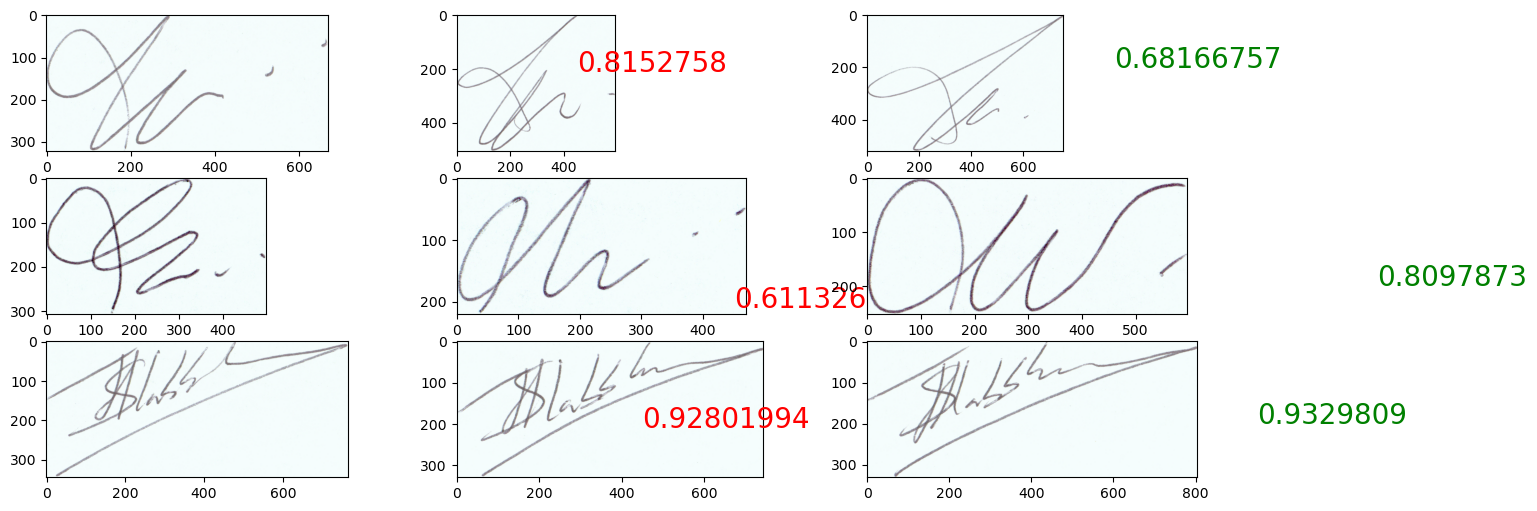

In [22]:
fig, axs = plt.subplots(3, 3, figsize=(15, 6), facecolor='w', edgecolor='k')


for i, cs in enumerate(cosine_similarities):
    axs[i][0].imshow(plt.imread(image_set[i][0]))
    axs[i][1].imshow(plt.imread(image_set[i][1]))
    axs[i][2].imshow(plt.imread(image_set[i][2]))

    axs[i][1].text(450, 210, cs['non_matching_pair_score'],fontsize = 20, color ="red")
    axs[i][2].text(950, 200, cs['matching_pair_score'],fontsize = 20, color ="green")

    axs[i][0].set_anchor('NW')
    axs[i][1].set_anchor('NW')
    axs[i][2].set_anchor('NW')

for ax in fig.axes:
    ax.set_yticks([])
    ax.set_xticks([])

for ax, col in zip(axs[0], ['Anchor Image', 'Negative Image', 'Positive Image']):
    ax.set_title(col)